In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Этот набор данных содержит результат A/B-тестирования, в ходе которого две группы, контрольная и экспериментальная, просмотрели старую веб-страницу и новую веб-страницу соответственно. Целью этого теста было определить, привела ли новая веб-страница к значительному увеличению числа конверсий по сравнению со старой веб-страницей. Каждая строка представляет уникального пользователя и показывает, принадлежат ли они к контрольной или экспериментальной группе, а также конвертировались они или нет.

Цель заключаеться в том, чтобы решить, будут ли изменения работать лучше для компании или нет.

In [1]:
import numpy as np 
import pandas as pd 
import scipy 
import matplotlib.pyplot as plt 
from scipy import stats

df = pd.read_csv('/kaggle/input/ab-testing/ab_data.csv')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
#проверяем есть ли пользователи в control группе, которые видели новую страницу, и 
#пользователи в treatment группе, которые видели старую страницу
df.groupby(['group', 'landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

In [4]:
#удаляем control-new_page and treatment-old_pge
df_cleaned = df.loc[(df['group'] == 'control') & (df['landing_page'] == 'old_page') | 
                  (df['group'] == 'treatment') & (df['landing_page'] == 'new_page')]
df_cleaned.groupby(['group', 'landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


In [5]:
#Проверка повторяюшихся значений
df_cleaned['user_id'].duplicated().sum()

1

In [6]:
df_cleaned[df_cleaned.duplicated(['user_id'], keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

In [7]:
df[df['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [8]:
df_cleaned = df_cleaned.drop_duplicates(subset='user_id', keep='first')

In [9]:
df_cleaned.groupby(['group', 'landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145310,145310,145310


<AxesSubplot: xlabel='group,landing_page,converted'>

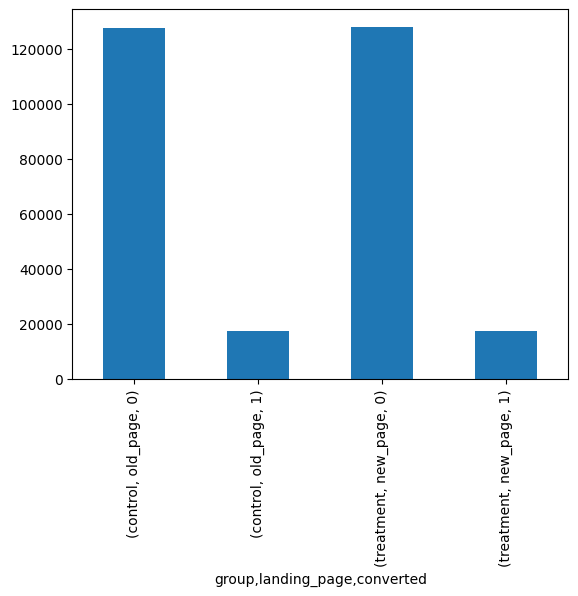

In [10]:
#Гистограмма конверсий для кадой группы
groups = df_cleaned.groupby(['group', 'landing_page', 'converted']).size()
groups.plot.bar()

<AxesSubplot: ylabel='landing_page'>

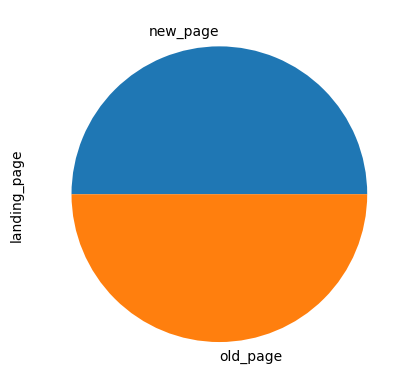

In [11]:
#Диограмма соотношения пользователей каждой группы
df_cleaned['landing_page'].value_counts().plot.pie()

In [12]:
# Переупорядочить данные в 2x2 для хи-квадрат
a = df_cleaned[df_cleaned['group'] == 'control']
b = df_cleaned[df_cleaned['group'] == 'treatment']

a_click = a.converted.sum()
a_noclick = a.converted.size - a_click
b_click = b.converted.sum()
b_noclick = b.converted.size - b_click

matrx = np.array([[a_click, a_noclick], [b_click, b_noclick]])

In [13]:
print(scipy.stats.chi2_contingency(matrx,correction=False)[1])


0.18988337448194853


Расчетное значение p равно 19%. Предполагая уровень значимости 5%, мы можем сделать вывод, что p-значение больше, чем альфа, и что мы не отвергаем нулевую гипотезу. Проще говоря, конверсии между старой и новой веб-страницей не имеют значения.

In [14]:
# Проверка работоспособности 
a_ctr = a_click / (a_click+a_noclick)
b_ctr = b_click / (b_click+b_noclick)
print(a_ctr, b_ctr, sep='\n')

0.1203863045004612
0.11880806551510564
